In [32]:
import gymnasium as gym
import os
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure

from evaluation.evalcallback_feedback import CurriculumEvalCallback

from gpt.utils import file_to_string

In [33]:
def load_curriculum_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)

    reward_dict = training_log["results_dict"]
    success = training_log["successes"].mean(axis=1)

    averaged_dicts = []

    for row in reward_dict:
        sum_dict = {}
        for col in row:
            for key in col:
                sum_dict[key] = sum_dict.get(key, 0) + col[key]

        avg_dict = {key: value/len(row) for key, value in sum_dict.items()}
        averaged_dicts.append(avg_dict)

    reward_df = pd.DataFrame(averaged_dicts)

    return reward_df, success

In [34]:
def load_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)
    
    reward_main = training_log["results"].mean(axis=1)
    try:
        success = training_log["successes"].mean(axis=1)
    except:
        success = None
    
    return reward_main, success

In [35]:
def extract_curriculum(logger_path):
    # extract curriculum and return list of dictionaries with task details
    curriculum_txt = file_to_string(logger_path + "curriculum.md")
    # Split the string into individual task sections
    task_sections = re.split(r'\n\n(?=Task)', curriculum_txt)

    # Function to extract details from each task section
    def extract_task_details(task_section):

        details = {}
        lines = task_section.split('\n')
        for line in lines:
            if line.startswith('Task'):
                details['Task'] = line.split(' ')[1]
            elif line.startswith('Name:'):
                details['Name'] = line.split(': ')[1]
            elif line.startswith('Description:'):
                details['Description'] = line.split(': ')[1]
            elif line.startswith('Reason:'):
                details['Reason'] = ': '.join(line.split(': ')[1:])
        return details

    # Extract details for all tasks
    curriculum_info = [extract_task_details(section) for section in task_sections]
    curriculum_length = len(curriculum_info)
    
    return curriculum_info, curriculum_length

In [36]:
def extract_best_agent(logger_path, curriculum_info, curriculum_length):
    task_list = []
    best_agent_list = []
    for idx in range(curriculum_length):
        curriculum_name = curriculum_info[idx]['Name']
        task_list.append(curriculum_name)
        try:
            decision = file_to_string(logger_path + curriculum_name + '.md')
            decision = decision.split('\n')[0]
            numbers = re.findall(r'\d+', decision)
        except:
            numbers = [0]
        if numbers:
            best_agent_list.append(int(numbers[0]))
        else:
            print(f"No number found in the decision {idx}")
            best_agent_list.append(0)
            
    return task_list, best_agent_list

In [62]:
reward_main = []
reward_task = []
success_list = []
task_length = []

In [63]:
logger_path = "./logs/AntMaze_UMaze/curriculum_1/"

curriculum_info, curriculum_length = extract_curriculum(logger_path)
task_list, best_sample_idx = extract_best_agent(logger_path, curriculum_info, curriculum_length)

In [64]:
for idx, task in enumerate(task_list):
    path = logger_path + task + f"/sample_{best_sample_idx[idx]}"
    
    reward_df, success = load_curriculum_training_log(path)

    for key in reward_df.keys():
        print(key)

    reward_main.append(reward_df["main"])
    reward_task.append(reward_df["task"])
    success_list.append(success)
    task_length.append(len(reward_df["main"]))

velocity_reward
orientation_reward
main
task
velocity_reward
orientation_reward
main
task
goal_distance_reward
velocity_reward
orientation_reward
main
task
goal_distance_reward
velocity_reward
orientation_reward
main
task
goal_reach_reward
goal_distance_reward
velocity_reward
orientation_reward
main
task


In [65]:
reward_main = np.concatenate(reward_main, axis=0)
reward_task = np.concatenate(reward_task, axis=0)
success = np.concatenate(success_list, axis=0)

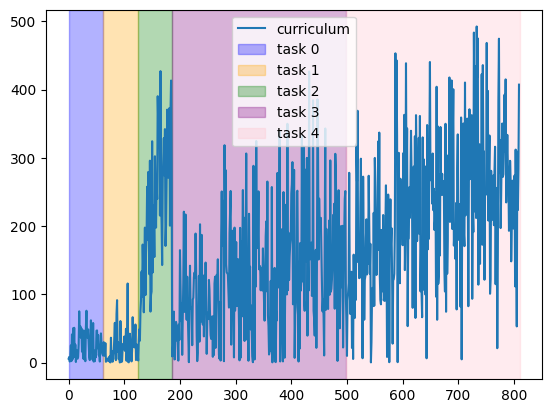

In [66]:
plt.plot(reward_main, label='curriculum')
n_tasks = len(task_length)
color_list = ['blue', 'orange', 'green', 'purple', 'pink', 'brown', 'olive']
for i in range(n_tasks):
    idx_start = sum(task_length[:i])
    idx_end = sum(task_length[:i+1])
    task_string = 'task ' + str(i)
    plt.axvspan(idx_start, idx_end, color=color_list[i], alpha=0.3, label=task_string)
# plt.plot(reward_main_addition, label='reward addition')
# plt.plot(reward_main_her, label='HER')
plt.legend()
plt.savefig(logger_path+"reward_main.png")

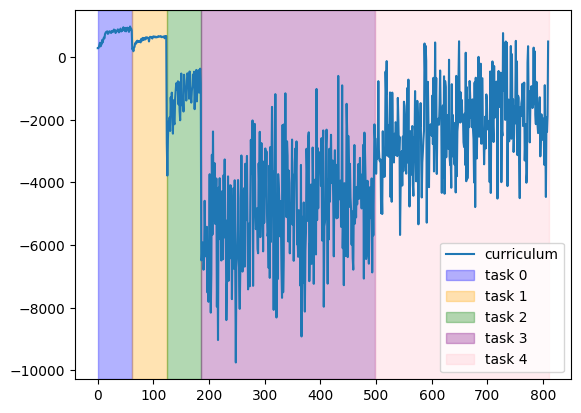

In [67]:
plt.plot(reward_task, label='curriculum')
for i in range(n_tasks):
    idx_start = sum(task_length[:i])
    idx_end = sum(task_length[:i+1])
    task_string = 'task ' + str(i)
    plt.axvspan(idx_start, idx_end, color=color_list[i], alpha=0.3, label=task_string)
# plt.plot(reward_task_addition, label='reward addition')
plt.legend()
plt.savefig(logger_path+"reward_task.png")

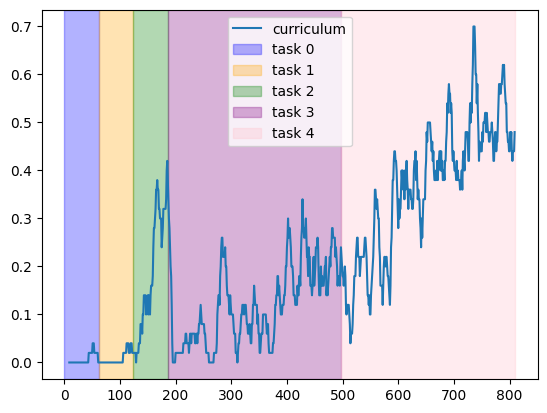

In [68]:
success_moving_avg = pd.Series(success).rolling(10).mean()
plt.plot(success_moving_avg, label='curriculum')
for i in range(n_tasks):
    idx_start = sum(task_length[:i])
    idx_end = sum(task_length[:i+1])
    task_string = 'task ' + str(i)
    plt.axvspan(idx_start, idx_end, color=color_list[i], alpha=0.3, label=task_string)
# success_addition_avg = pd.Series(success_addition).rolling(10).mean()
# plt.plot(success_addition_avg, label='reward addition')
# success_her_avg = pd.Series(success_her).rolling(10).mean()
# plt.plot(success_her_avg, label='HER')
plt.legend()
plt.savefig(logger_path+"success.png")

# Env Test

In [61]:
import Curriculum

#env = SubprocVecEnv([make_env("AdroitHandRelocate-v1", i) for i in range(2)])
# env = make_vec_env("Curriculum/AdroitHandRelocate-v1", n_envs = 2)
env = gym.make("Curriculum/AntMaze_UMaze-v2", render_mode="rgb_array")

DeprecatedEnv: Environment version `v2` for environment `Curriculum/AntMaze_UMaze` doesn't exist. It provides the default version `Curriculum/AntMaze_UMaze`.

In [ ]:
env.reset()
camera_config = {'distance': 4.0,
                 'azimuth': 10.0,
                 'elevation': 5.0}
env.ant_env.mujoco_renderer.default_cam_config

In [ ]:
print(env.ant_env.mujoco_renderer._get_viewer(render_mode="human"))

In [ ]:
obs = env.reset()
print(obs[0])

# model = SAC.load("./logs/AntMaze_UMaze_SAC/goal_orientation/sample_0/final_model.zip")

# for i in range(100):
# #     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, _, _, info = env.step(env.action_space.sample())
#     print(obs)
#     for key in info.keys():
#         print(key)

In [ ]:
goal_pos = obs['desired_goal']
xyz_coord = obs['observation'][0][:3]
print(xyz_coord)
distance= np.linalg.norm(goal_pos - xyz_coord[:2])

distance

In [ ]:
-np.linalg.norm([1.3408, 0.75647, 0.41671] - [0.144742, 0.8211249, 0.42469975]) + 

In [ ]:
rewards

In [ ]:
model.policy